# Project Basics of mobile robotics 2022-2023

This project was done in the scope of the course MICRO-452 Basics of mobile robotics  by the group 38 who members are : 
- Axel Praplan
- Romain Bianchi 
- Oliver Ghysen
- Albias Havolli 

# 1. Introduction
In this section, we will describe our environment and the choices we made. One of the main goals of the environment choice was to keep things simple, but we didnt want to create too many constraints either. It should be usefull in an environment that doesnt need to be prepared beforehand (by adding a pattern on the floor for example).

We decided to use a continuous white map with black 2D obstacles, to have the highest contrast possible. As they are 2D we can make sure we're using the global navigation instead of relying on the thymio's proximity sensors. The black obstacles are polygons, so they can be described by a list of corners. To track the Thymio itself, we provided it with two coloured dots. By tracking these dots with the camera we know both the location and orientation of the thymio. Finally, the thymio's goal can be any object and will be tracked by using template matching. 

To detect the obstacles, we use a sobel filter, combined with a hough transform to detect edges. A big advantage of this method is that we can make any choice of colours, as long as the contrast is big enough. We also get an analytical parametrisation for the lines, making it easy to enlarge obstacles, followed by using Dijkstra's algorithm to determine the optimal path. The thymio itself is a finite state machine. When it doesnt detect any obstacles, it follows the optimal path. As soon as an obstacle is detected, it switches to local navigation and uses its proximity sensors to avoid obstacles.


# 2. Implementation

# 2.1 Importing libraries and py files

In [1]:
import pyvisgraph as vg
import numpy as np
import matplotlib.pyplot as plt
from global_navigation import *
from obstacleDetection import *
import math


## 2.2 Initialization

Choices make for navigation and detection, use of the camera...

## 2.3 Obstacles detection
As explained in the introduction, we placed black, 2D, polygonial obstacles on the white map. To detect these obstacles we follow these main steps: 

Use a sobel filter to get edges out of the picture, apply a hough transform to get the parametrisation of these edges and combine the lines in a graph to create obstacles. 

This would be a bit more complicated that tresholding the image (simply discarding the white pixels and keeping the black ones), but the result would be a list of corners which allows us to make a visibility graph and to analyticaly define a path (by using dijkstra). This way we could use a simple PID controller to follow the lines, so we wouldnt have to make a something complicated like a vector field.

Unfortunately programming this turned out to be more difficult than expected, so the resulting code is quite long. The help files relating to this section all start with cv_ and the main file that calls all the functions is obstacleDetection.py 

### First step: image processing
The first unexpected problem was that we have multiple obstacles in one picture, now the hough transform becomes way less accurate. There are more accidental overlaps between nonmaxima (which are then detected as lines) and there is a lot of interference between the lines of the obstacles. 

To solve this problem, we start by splitting the picture into chunks. When one of the pixels at the border of this chunk is black, we fuse the chunk with its neighbour. By repeating this process we retrieve all individual objects out of the picture. 

Whenever the hough transform intersection is slightly inaccurate, the intersection of two lines (a potential corner of an obstacle) might fall outside of the picture. To prevent this, the map is surrounded by a white border before cutting it into chunks and each individual object is later also surrounded by an extra white border. The image is loaded in grayscale to differentiate between the light background and dark obstacles. To ensure there is no big contrast between the border and the background, we use the minimumal value from the top of the background, not 255.

We demonstrate these steps with the code below:

 
Splitting file into chunks
- file: PICTURES/map_without_thymio7_12.png
- type: <class 'numpy.ndarray'>
- resolution: (720, 1080)


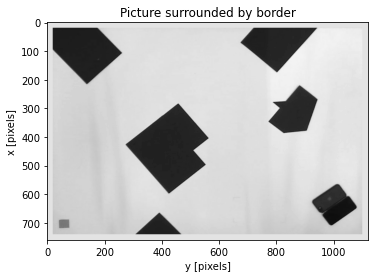

Displaying obstacle: 0


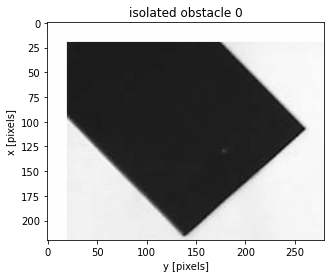

Displaying obstacle: 1


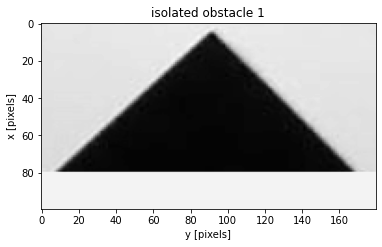

Displaying obstacle: 2


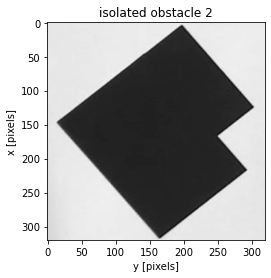

Displaying obstacle: 3


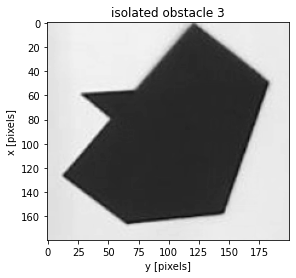

Displaying obstacle: 4


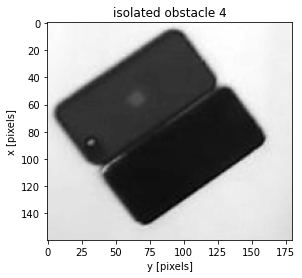

Displaying obstacle: 5


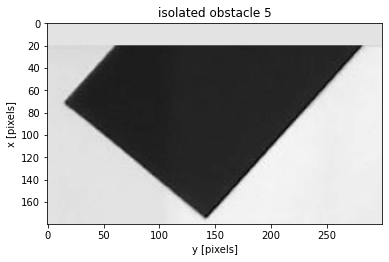

In [2]:
# settings for this example
import cv_settings
cv_settings.current_test = 'picture07/12'
visualsProfile2()
settingsProfile1()

# split the map into chunks
chunkedMap = GridMap.GridMap(cv2.imread(settings.getFILENAME_MAIN(), cv2.IMREAD_GRAYSCALE), settings)

# fuse the chunks into bigger png's with (hopefully) one obstacle each
chunkedMap.fuseAllBorders()

# display the results
chunkedMap.displayAllISolatedObjects()  # optional

Now we have individual obstacles, we can analyse them one by one. First, a border is added around the picture and it is saved. 

In [3]:
# get one of the obstacles
for obstaclePng in chunkedMap.obstaclesPng:
    pass
i=0

# normally inside the for loop
# add border
obstaclePng.data = chunkedMap.addBorder(obstaclePng.data)
# save figure
filePath = chunkedMap.saveFig(i, obstaclePng)
# create Picture object
pictureData = Pictures.Picture(cv2.imread(filePath, cv2.IMREAD_GRAYSCALE), filePath, i, settings)

 
Anaysing picture: 0


Then we blur the image with a bilateral filter to get rid of noise, we chose this type of blurring filter because it preserves edges.

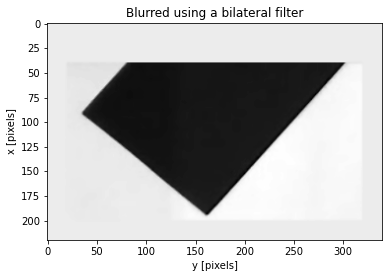

In [4]:
blurredImage = pictureData.blurImage(pictureData.data)

We then retrieve the edges by using a 2 directional sobel filter, alternatively a canny or laplacian filter could be used, but we felt like the sobel filter gave us the best results.

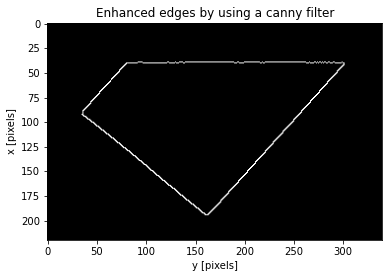

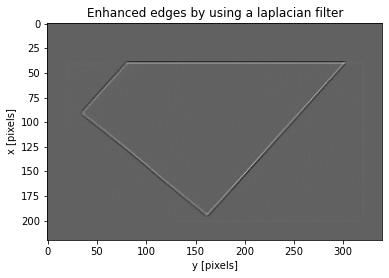

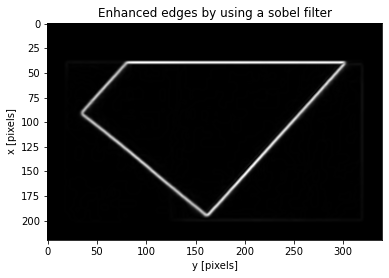

In [5]:
n = pictureData.edgeEnhance(blurredImage, 'canny')
n = pictureData.edgeEnhance(blurredImage, 'laplacian')
edgeEnhancedImage = pictureData.edgeEnhance(blurredImage, 'sobel')

Now, we treshold the edges. By choosing a high treshold we already get a sharp result

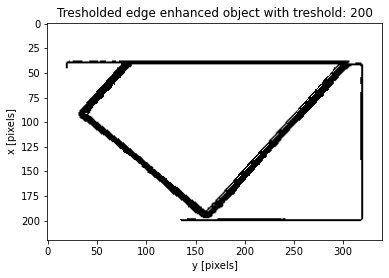

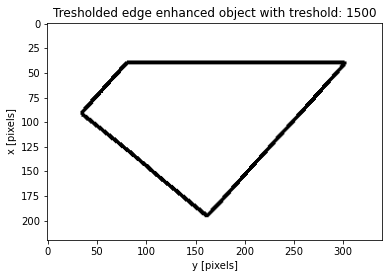

In [6]:
# normally inside the for loop
n = pictureData.treshold(edgeEnhancedImage, black = 200)
tresholdedImage = pictureData.treshold(edgeEnhancedImage)

After tresholding we want to supress the non maxima to get the sharpest possible result. To do this we use the cv2 functions dilate & erode. For these functions we use a kernel with a plus shape so we dont destroy diagonal edges. For grainy pictures like the one above with treshold 200 it is usefull to dilate first, but for the clean result we found it is best to set dilation iterations to 0.

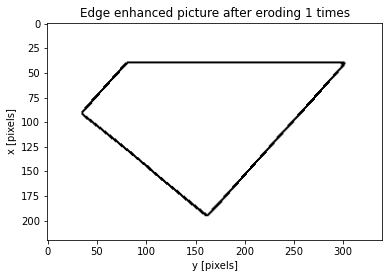

In [7]:
# normally inside the for loop
dilatedImage = pictureData.dilate(tresholdedImage) 
erodedImage = pictureData.erode(dilatedImage)
pictureData.processedData = erodedImage

Now the image is ready to be transfomed into its hough transform. For the hough transform we used the parametrisation that can be seen in the figure below.

We based the code to do this on the code provided in the solution of exercise session 2, but increased the dimensions of the hough matrix to increase the angular precision. The rounding order was increased from 1 to 2 (for an accuracy of 0.5 degrees instead of 5 degrees) and instead of theta going from 0 to 2*PI, we go from -PI/2 to 3*PI/2. The reason we do this is this is because when a horizontal line is analysed, the bright spot in the map is split into two spots (one all the way on the left and one all the way on the right). If we then retrieve maxima, we get two lines that are slightly non-horizontal, rather than one. 

We also noticed that lines situated in theta between PI and 3/2*PI are always outside of the image, so they do not need to be taken into consideration during the rest of the process and coult be removed by reducing the maximum angle to PI.

### Hough transform.

<br/>

![System 1](./report_images/hough_analysiss.png)

<br/>

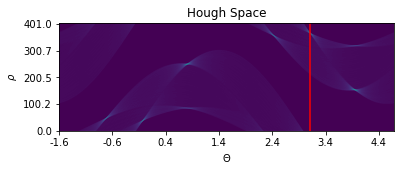

In [8]:
# normally inside the for loop
# the hough transform is calculated to find edges
houghTransform = pictureData.calculate_hough_transform(pictureData.processedData)

The hough space should now be tresholded and dilated to retrieve the local maxima. 

We added a step before the treshold, to cale the hough space so that the maximal value can be chosen. This way we ensure that the program works with the one same treshold for images of different resolutions. For example, a 4k image will have more pixels and will therefore have a brighter hough space than a 1080p image, but by scaling them so they both have maximum 255, the hough spaces will look more similar. 

The tresholded hough space is also not only dilated, but also eroded a bit again. We hoped eroding would increase precision, but are unsure if it actually helps or not. The dilating step however is essential as it fuses the small sparkles around a maximum together with the maximum. Because we will erode afterwards, we can dilate a few extra iterations.

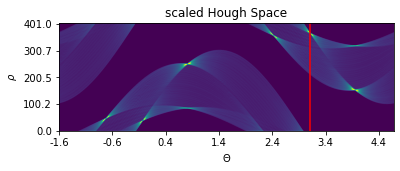

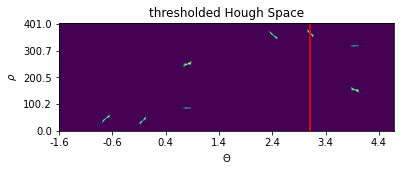

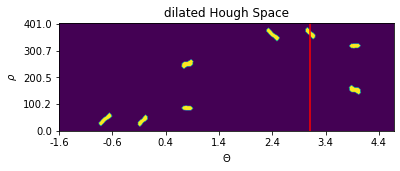

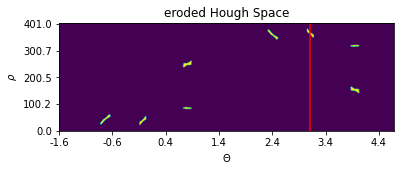

In [9]:
# normally inside the for loop
# the hough transform is scaled
houghTransform = pictureData.enhanceHough(houghTransform)
# find maxima from the hough space
maxima = pictureData.find_optima(houghTransform)

### Second step: retrieving lines
Now we have retrieved the maxima, we change back to the y = mx+b parametrisation. For every line, we calculate where they intersect with other lines and discard intersections outside of the image. Here there is a special case for horizontal lines, causing m to be infinite. This increased the complexity of the code, by a ton. Sometimes there would also be multiple lines coming out of the origin of the picture. These cause the intersections to overlap and later to compute the graph we have to order them, so we discard these.

Note that in the case of complicated objects, the lines are ofter still slightly off. There is still some room for improvement here, but since we enlarge them later on, slight inaccuracies are not fatal in this project.

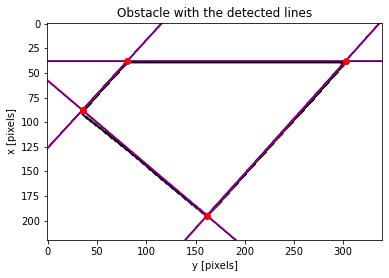

In [10]:
# normally inside the for loop
# calculate lines & intersections , visualise
pictureData.find_all_lines_from_maxima(maxima)
pictureData.find_intersections_from_lines()
pictureData.visualiseLinesAndIntersections()  # optional

### Third step: making a graph
Now we have a list of intersections, sorted per line. We will use this list to make a graph where each node is an intersection, connected to its neighbouring nodes with the lines. To connect nodes to their neighbour, we first sort them on basis of x coordinate (and y coordinate for horizontal lines). The first neighbour is then the one on the upper right and we continue clockwise. 

In [11]:
# normally inside the for loop
# create Map object, at this level we use lines & intersections to make and analyse a graph
obstacleMap = Maps.Map(filePath, time.time(), pictureData)

# sort the intersections, use them to make a graph out of the intersections (nodes with neighbours)
obstacleMap.sortIntersections()
obstacleMap.makeGraph()

there are 4 intersections


Now we have a graph with nodes and neighbours, we can make small loops. Starting with any node, we start with any of the four possible directions and navigate through the graph in a clockwise manner until we're back at our starting point. As we do this for every node, for every start direction, we will have duplicate loops. We remove these before going to the next step.

there are 1 distinct loops
SHOWING SEPERATE CLOSED LOOPS


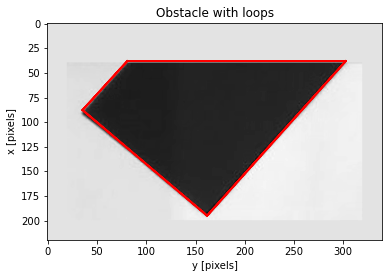

In [12]:
# normally inside the for loop
# use the neighbours to make closed loops of neighbours , visualise
obstacleMap.makeLoops()
obstacleMap.visualiseLoops()  # optional

Now we have loops, we can check if they are coloured white or black by taking a sample in their centre. If the centre is white, the loop is discarded. Neighbouring loops (if they share an edge) also have to be fused by appending the unique edge and discarding the shared edge. 

there are 1 obstacles


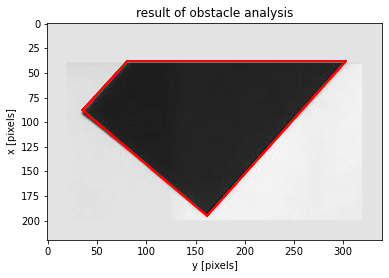

In [13]:
# normally inside the for loop
# keep black loops, discard white loops (these are a byproduct of lines intersecting outside of the obstacle)
obstacleMap.getObstaclesFromGraph()
obstacleMap.visualiseObstacles()  # optional

We are now done analysing this obstacle, but still need its coordinates to be converted back to the global coordinate system. First, we move each obstacle back to the global system by adding its individual offset, then we remove the border from the set of obstacles (with a shared offset).

there are 1 obstacles


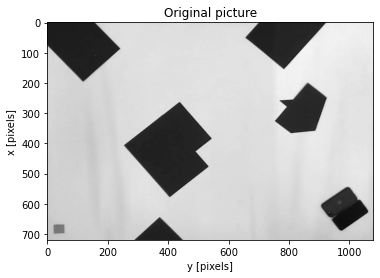

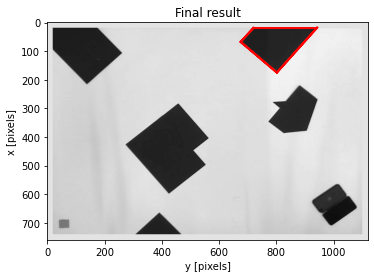

In [14]:
# normally inside the for loop
# all the obstacles we found were returned in a local reference frame -> transform to global map & add to global set
chunkedMap.convertObstaclesToGlobal(obstacleMap, obstaclePng)

# outside the for loop
# repeat as we have 2 borders: both for exterior border and individual borders
chunkedMap.convertObstaclesToGlobal()
# display the results
chunkedMap.displayGlobalObstacles()  # optional

### Last step: exporting
Now we retrieved all the obstacles from the map, we have to convert them into a format that is usable to create the visibility graph. We flip the X&Y axis and the visibility graph package uses their own vg.point and stores the obstacles in a list:\
[obstacle1, obstacle2,...]\
These obstacles are lists themselves:\
[corner1, corner2, corner3,...] \
with vg.point's as corners.

The program crashes if there are three corners along the same line. Unfortunately this is a byproduct of how we fuse the loops into obstacles in one of the earlier steps, so we adress this by simplifying the obstacles before exporting: Remove 'corners' along a line and remove corners that are extremely close to each other.

This is the final result.

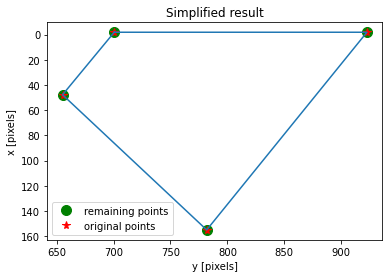

In [15]:
# export in a format suitable for the visibility graph:
# [[corners_of_obstacle_1],[corners_of_obstacle_2]...]
# with the corners a list of vg.Point(), ordered so that they can be followed into a loop
output = chunkedMap.exportGlobalObstaclesFlippedXY()  # uses self.globalObstacles:

# sometimes there are multiple points along the same line, delete these
# (otherwise program crashes later when they use cos rule)
simplifiedoutput = chunkedMap.simplify(output)

# display result
chunkedMap.displaySimplified(output, simplifiedoutput)

All these steps and the for loop are impelemented in the command analysePicture2() in the obstacleDetection.py file. To easily switch between settings we also made different profiles which can, but dont have to be called when initialising the program. The program will also always look for a file 'map_without_thymio.png' which should be provided in the same folder, but other pictures can be used by changing settings.current_test.

Example usage of the code:

 
Anaysing picture: 0


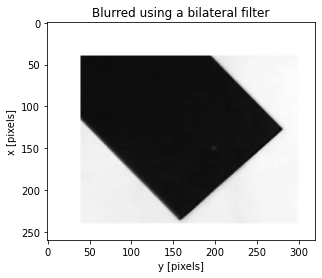

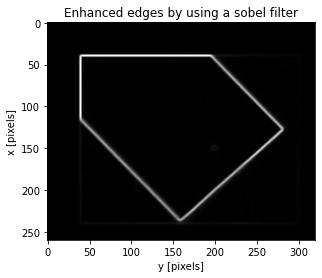

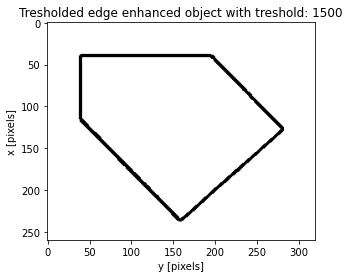

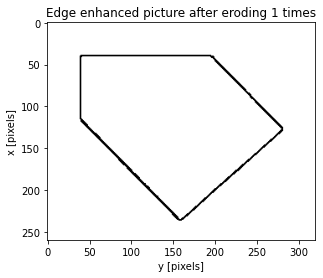

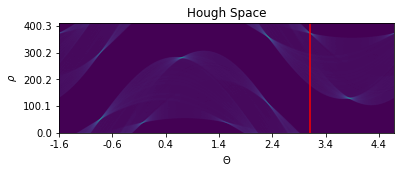

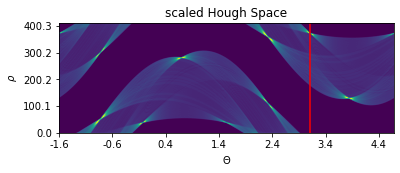

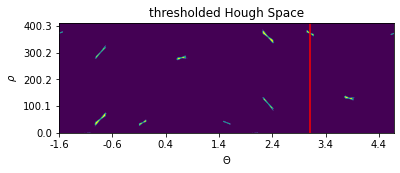

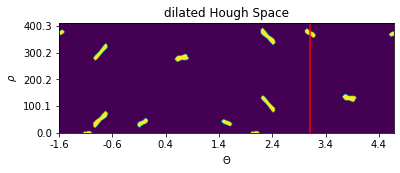

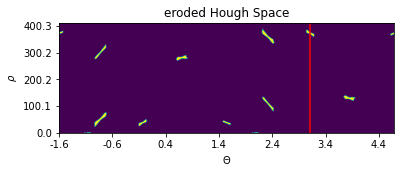

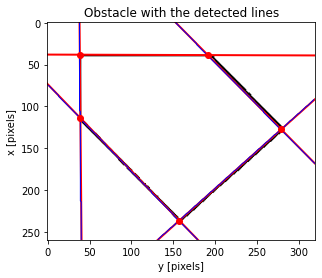

there are 5 intersections
there are 1 distinct loops
SHOWING SEPERATE CLOSED LOOPS


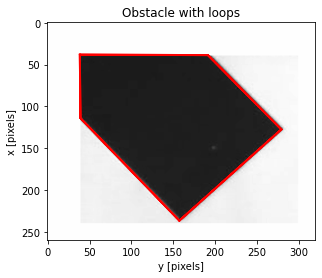

there are 1 obstacles


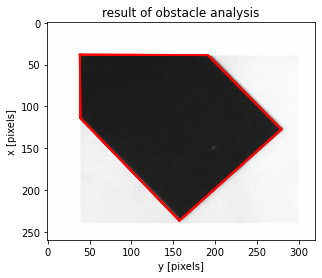

 
Anaysing picture: 1


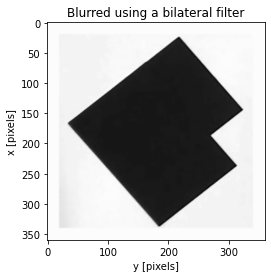

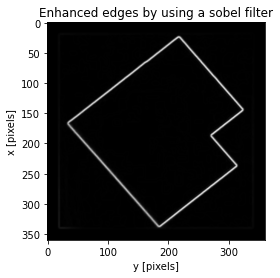

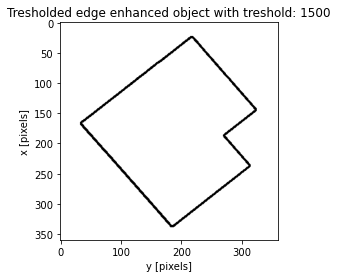

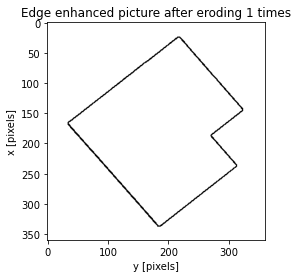

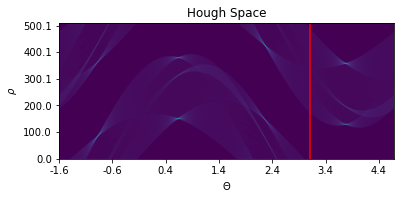

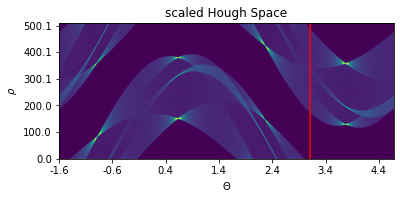

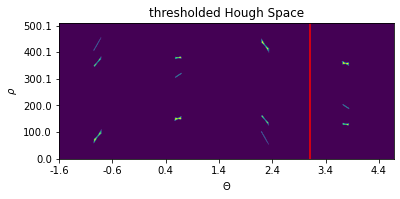

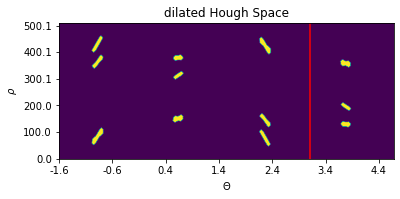

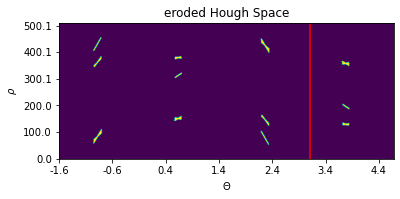

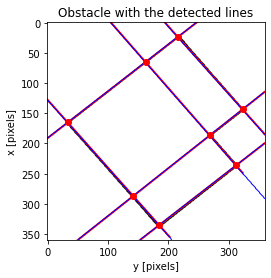

there are 8 intersections
there are 3 distinct loops
SHOWING SEPERATE CLOSED LOOPS


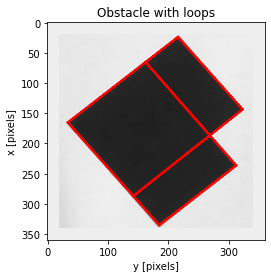

there are 1 obstacles


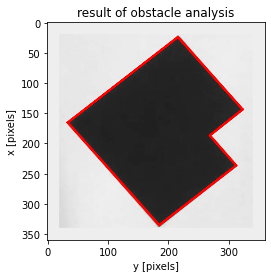

 
Anaysing picture: 2


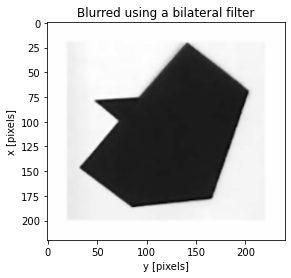

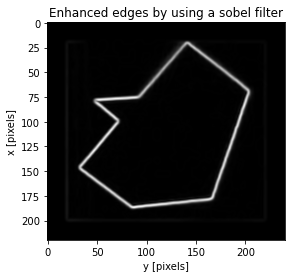

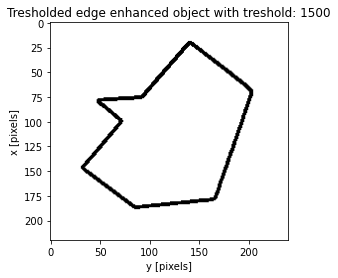

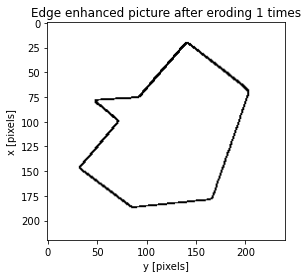

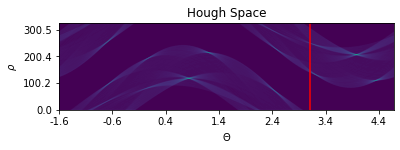

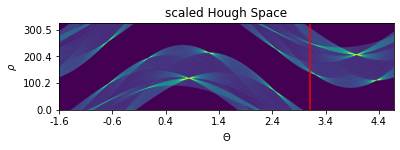

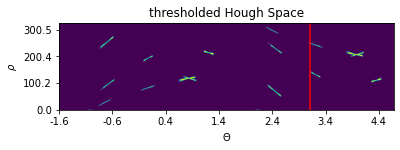

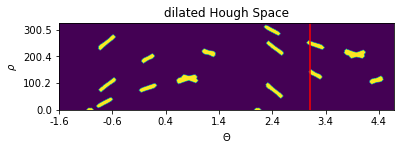

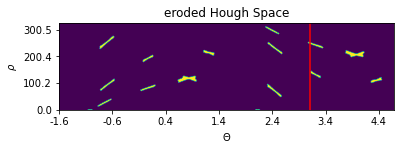

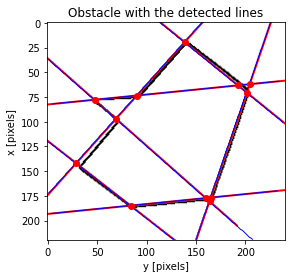

there are 12 intersections
there are 6 distinct loops
SHOWING SEPERATE CLOSED LOOPS


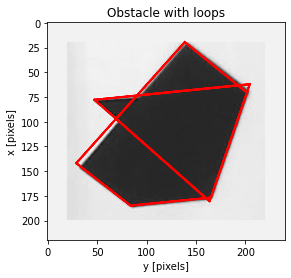

there are 1 obstacles


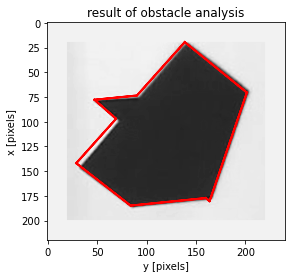

 
Anaysing picture: 3


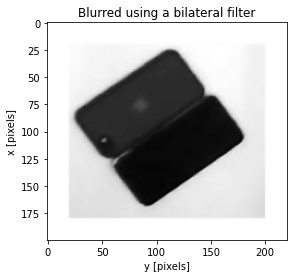

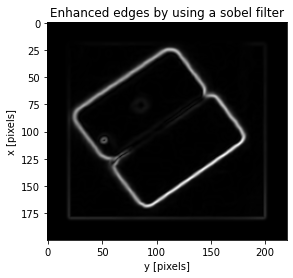

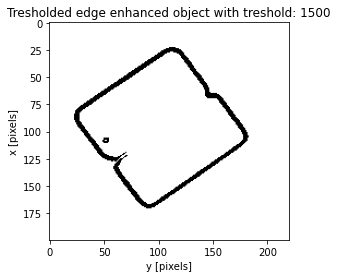

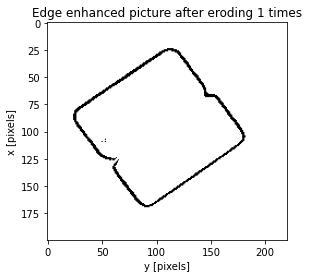

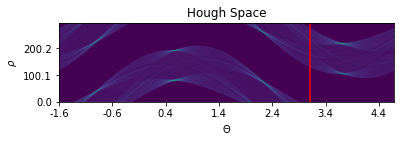

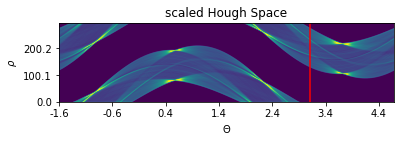

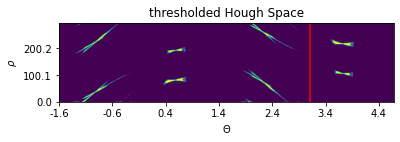

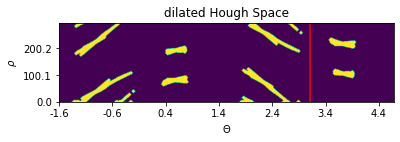

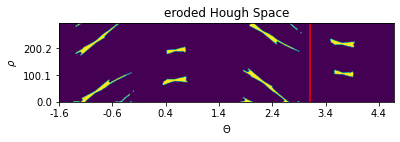

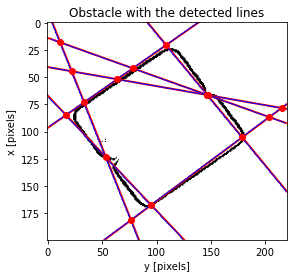

there are 16 intersections
there are 10 distinct loops
SHOWING SEPERATE CLOSED LOOPS


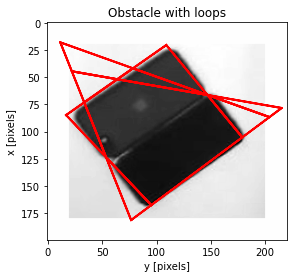

there are 1 obstacles


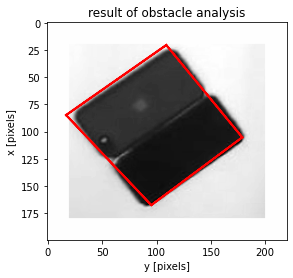

 
Anaysing picture: 4


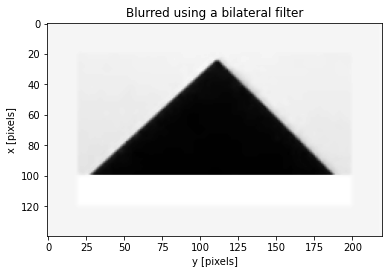

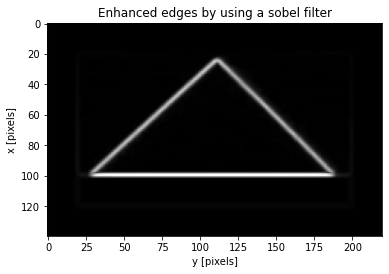

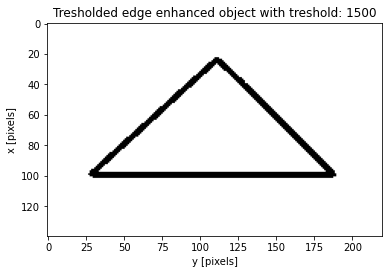

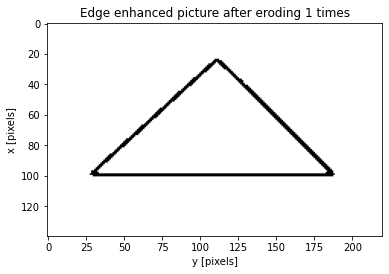

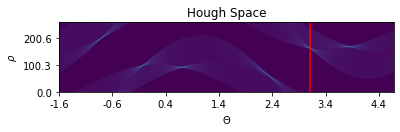

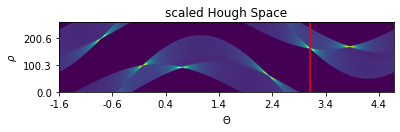

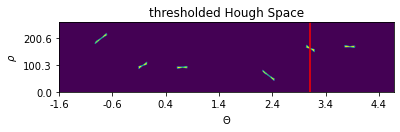

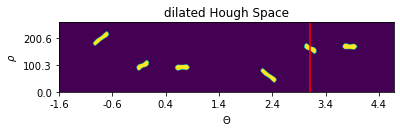

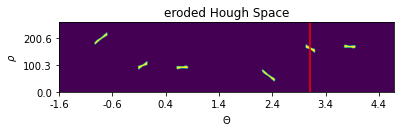

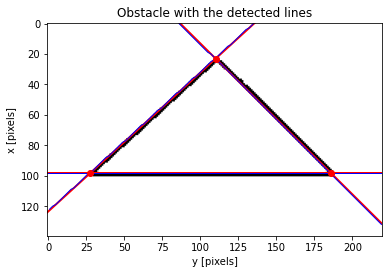

there are 3 intersections
there are 1 distinct loops
SHOWING SEPERATE CLOSED LOOPS


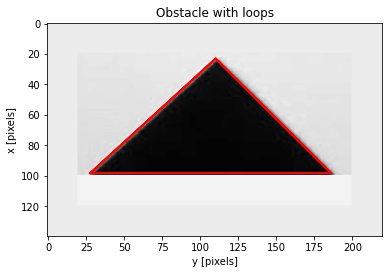

In [ ]:
# settings for this example
import cv_settings
cv_settings.current_test = 'picture07/12'
# note that normally a picture has to be stored at map_without_thymio.png
# visuals profiles:
# 0: minimal output, 
# 1: allows to remove obstacles, the thymio itself for example
# 2: all steps are shown
visualsProfile0() 
settingsProfile1()
chunkedMap, polys, thymiowidth = analysePicture2()

# the result can be saved in a string format to save time:
string = savePoints(chunkedMap, polys, thymiowidth)

# the result can be re-opened:
thymiosize, minx, miny, maxx, maxy, obstacles = getPolys(string)

A big advantage of using this technique is that it can be used on any background, as long as there is a decent contrast between the obstacle and the background. Only the 'black' treshold would need to be changed if we were to use a different colour. To demonstrate this, we rerun the program on a wooden background.

### Hough transform.

<br/>

![System 1](./report_images/woodBackGround.png)

<br/>

In [ ]:
import cv_settings
# small note: the first step, isolating black objects, 
# will isolate a lot of black parts of the wood, 
# but the program doesnt consider these as objects 
# because they dont survive the erosion step
visualsProfile0() 
settingsProfile1()
cv_settings.current_test = 'wooden background'
cv_settings.GRIDMAPBLACKTRESHOLD = 100
cv_settings.MAPBLACKTRESHOLD = 100
chunkedMap2, polys2, thymiowidth2 = analysePicture2()

## 2.4 Global navigation

Assuming that the outputs of the previous parts are a set of polygons representing the obstacles and the start&goal points:

In order to take into account the width of the Thymio, we enlarge the obstacles by applying an homothety so that the Tyhmio does not enter in collision with the obstacles. The homothety's center is the centroid of the polygon. In other words, given the polygon's set of corners, firstly, the polygon's centroid is given by the centroid() function. After that, given the same polygon and its centroid, the homothetyl() function returns the set of node of the enlarged obstacle. The way we do this is creating a vector from the centre of an obstacle to (and perpendicular to) each edge of this obstacle. We then enlarge it by half the width of the thymio and create a new edge, perpendicular to this vector. This is demonstrated in the figure below. After calculating where these new edges intersect, we have the corners of the enlarged obstacle.

This works well for all convex obstacles, other obstacles may sometimes be enlarged in the wrong direction (shrunk), as can be seen in the last example of this section.

### Enlarging obstacles.

<br/>

![System 1](./report_images/enlargepoly.png)

<br/>

We use these enlarged obstacles to compute a visibility graph. Each node in the graph represents a unique point in the map. These can be the corners of obstacles and the start & end point for the thymio.
Two nodes are neighbours if they can see each other. This means the line segment connecting the nodes does not pass through any edges. These edges can come from both the obstacles in the map and the border surrounding the map.

important data structures are:

- self.edges: stored here all the edges (both from objects and map border)
    An edge is defined by two points
    An edge is used to check if and where it intersects with two points trying to 'see'
    each other
    By adding border edges to this set we solve problem 1
- self.points: stored here are all the points (from objects, start & end point, but not
    from the border)
- self.triangles: stored here are all the objects, split into triangles (from objects)
    by splitting an object in triangles, we can use vector theory to assert whether or not
    a point lies within this object or not. This allows us to solve problem 2
- self.can_see: a primitive version of the graph, it is later converted to self.graph
- self.graph: a dictionary that, given a point, returns all the other points this point can
    see
    upon calling self.graph[point_a][point_b], if point_a and point_b can see each other,
    the distance between these points is returned
- self.pointCoords is kept to assert all points are unique
        
To determine wether a point P lies within an obstacle, we split the (convex) obstacles into triangles and use vector analysis and check if the point lies in one of these triangles: calculate C & T such that c0 + C*v1 + T*v2 = P. If 0 < C < 1 & 0 < T < 1 & C + T < 1: the point lies in the triangle. This is demonstrated in the image below.

After the visiblity graph is computed, we use the Dijkstra's algorithm to compute the shortest path from the start point to the goal point. The resulting ouput will be an ordered list of points representing different nodes in the visiblity graph. This is the shortest path. 

To avoid the algorithm dijkstra crashing when one of the unvisited nodes is unreachable (for example when a point lies inside an obstacle), the algorithm was slightly altered to handle u (the unvisited node with the lowest distance) = None while there are still nodes in Q (the list with unvisited nodes)

We tried to make this work with the library pyvisgraph (1). The library allows us to compute the shortest path between two points givent a set of obstacle polygons. Unfortunately we found no way to add a border to the package and after enlarging objects, if they overlapped, the package would compute routes going through the obstacles, rather than around them. This problem can not simply be solved by making sure obstacles dont touch each other: the problem is that after enlarging the obstacles they overlap, meaning the thymio cannot pass through here. We demonstrate these two problems with the examples below.

In [ ]:
# setting a starting and goal points for both problems and a set of obstacles

start_point_1 = vg.Point(5,-5)
goal_point_1 = vg.Point(15,8)

start_point_2 = vg.Point(-6,-5)
goal_point_2 = vg.Point(0,6)

polyg = [[vg.Point(-5,1.5), vg.Point(10,4), vg.Point(5,0)],
         [vg.Point(10.0,-5.0), vg.Point(12.0,5.0), vg.Point(22.0,5.0), vg.Point(24.0,-5.0)]]

poly_pbm_1 = polyg.copy()
poly_pbm_2 = polyg.copy()
poly_sol_1 = polyg.copy()
poly_sol_2 = polyg.copy()

### Problem 1.

In [ ]:
### code for going into overlapping obstacles and using pyvisgraph package
short,_ = path_planning(poly_pbm_1, start_point_1, goal_point_1,1.1,minx=-15,miny=-10,maxx=30,maxy=20,usePackage=True, showGraph = False)

### Problem 2.

In [ ]:
### code for going outside of the map and using pyvisgraph package
short,_ = path_planning(poly_pbm_2, start_point_2, goal_point_2,1.1,minx=-8,miny=-10,maxx=30,maxy=20,usePackage=True, showGraph = False)

Because of these problems, we made our own visibility graph file, where we made two alterations: 
When the visibility graph is computed, we check if a point lies inside another object. If it is inside, it is unable to see anything. This way we work around the first problem.
When initialising the graph, we also add a border (from minimum & maximum x and y coordinates). If a gridMap (from section 2.3) is provided, we automatically use the dimensions of the map.
This code works well for all convex obstacles. For concave obstacles, they are made convex by connecting each corner to every other corner, so any point 'in' a convex area is no longer reachable.



### Solution problem 1.

In [ ]:
### code for going into overlapping obstacles with our own pyvisgraph function
short,_ = path_planning(poly_sol_1, start_point_1, goal_point_1,1.1,minx=-15,miny=-10,maxx=30,maxy=20,usePackage=False, showGraph = False)

### Solution problem 2.

In [ ]:
### code for going outside of the map with our own pyvisgraph function
short,_ = path_planning(poly_sol_2, start_point_2, goal_point_2,1.1,minx=-8,miny=-10,maxx=30,maxy=20,usePackage=False, showGraph = False)

These steps are all executed by calling one command: path_planning(), which returns a list containing the shortest path and the enlarged polygones (to be used later).

Input arguments are:

- polygones: a list with the obstacles in the form:\
    [[first corner of obstacle 1, second corner of obstacle 1, ...], 
    [first corner of obstacle 2, second corner of obstacle 2, ...], ...]
    The corners here are vg.point's;\
- start_point: a vg.point representing the thymio's starting position;\
- goal_point: a vg.point representing the thymio's goal;\
- k: an integer representing half the thymio's width in pixels

When calling the function a gridMap should be provided so the size of the map can be used to define the border and provide a background to the visibilitygraph. To increase the speed of this notebook however, we also implement the code without gridmap, but then integers for the border have to be provided. A user can also easily switch between the pyvisgraph package and our implementation by setting usePackage to True and False respectively.\

- gridMap: the gridMap or None, default None;\
- minx: None or the minimal x for the border if no gridMap is provided, default None;\
- miny: None or the minimal y for the border if no gridMap is provided, default None;\
- maxx: None or the maximum x for the border if no gridMap is provided, default None;\
- maxy: None or the maximum y for the border if no gridMap is provided, default None;\
- usePackage: A boolean expressing wether or not the pyvisgraph package should be used, default False

The function returns the shortest path and the enlarged polygons. There are also two plots: one showing the internal representation of obstacles (black edges) and one showing the result with the picture in the background.


In [ ]:
# A simple example with one obstacle:

# start point is defined in the next section. -> temporary example:
# end point is defined in the next section. -> temporary example:
start = vg.Point(1,1)
end = vg.Point(chunkedMap.originaldata.shape[1]-1, chunkedMap.originaldata.shape[0]-1)
# example code, assuming a gridMap and polygones, start and end point 
# and thymio width are already defined in section 2.3:
shortest, polygones = path_planning(polys2.copy(), start, end, thymiowidth/2, gridMap = chunkedMap2)

In [ ]:
# Multiple obstacles, the one on the top deforms in the wrong direction because its concave

# start point is defined in the next section. -> temporary example:
# end point is defined in the next section. -> temporary example:
start = vg.Point(1,1)
end = vg.Point(chunkedMap.originaldata.shape[1]-1, 1)
# example code, assuming a gridMap and polygones, start and end point 
# and thymio width are already defined in section 2.3:
shortest, polygones = path_planning(polys.copy(), start, end, thymiowidth/2, gridMap = chunkedMap)

## 2.5 Computer vision

Detection with colors, template matching for the end, reshaping of the map

In [ ]:
#code

## 2.6 Filtering

Kallman filter, prediction if no camera...

In [ ]:
#code 

## 2.7 Motion control
This section describe the motion control of the robot along the global path and the local obstacle avoidance. All the control is implemented in the function "navigation" that is called for every iteration of the main while loop. the "robot", "pidA" and "pidP" classes and outputs are used to update all the informations about the robot's states and the two PID controllers every time the main loop is done. An array with all the points of the optimal path is also given as an input as well as the proximity sensors values and the previous speeds.


## 2.7.1 global navigation part

The main idea of the control is to define a line to follow between the previous and the next point in the optimal path. This line is defined with those two points and its angle from the horizontal. Two PID controllers are then used to make the robot follow the line, one to track the line angle and one to ensure that the distance between the robot's center of roatation and the line stay close to zero. Every time the robot reach its next goal point along the path, the line is redefined from the actual point to the next point of the path.

The parameters of the two PID controllers where determined exprimentaly by a classical tunning process. We first tuned the orientation PID to track the angle and then added the one for position. Actually, we saw that de derivative component of the controllers wasn't really useful so it's implemented in the code but used with a derivative gain of zero resulting in a PI control of the position. 

The simple final step machine bellow illustrate the global navigation implementation.

IMAGE FSM A AJOUTER

## 2.7.2 Local navigation part

COMPLETE HERE FOR LOCAL MOTION CONTROL

## 2.7.3 Motion control test

The two cells bellows provide a simple demonstration of the motion control by making the robot follow a predefined path of three points without any obstacle detection by computer vision. It also allow to test the local obstacle avoidance by adding object on the path. By running the previous cells of the notebook the required initialization should already have been done.

Note that the predefined path start from the position of the robot, make it goes on the right and then up, so in order to test it properly it's better to begin with the thymio on the bottom left of the map.

By running the first cell bellow the local navigation code is loaded on the thymio

In [ ]:
%%run_python
globalL = 0
globalR = 0
avgProx = [0,0,0,0,0]
timer_period[0] = 10
n = 5
sensor_scale = 200
to_close = True

# This program implements obstacle avoidance using an ANN
@onevent
def buttons():
    global n, sensor_scale
    if button_forward == 1:
        n += 1 
    if button_backward == 1:
        n -= 1
        if n <= 0:
            n = 10    
    if button_left == 1:
        sensor_scale -= 10
        if sensor_scale <= 0:
            sensor_scale = 10        
    if button_right == 1:
        sensor_scale += 10


# State for start and stop
@onevent
def timer0():
    global prox_horizontal, motor_left_target, motor_right_target, button_center, state, n, sensor_scale

    w_l = [40,  20, -20, -20, -40,  30, -10]
    w_r = [-40, -20, 20,  20,  40, -10,  30]

    # Scale factors for sensors and constant factor
    constant_scale = 20
    
    for i in range(5):  
        avgProx[i] = (avgProx[i]//n)*(n-1) + prox_horizontal[i]//(n)
    
    y = [0,0]
    x = [0,0,0,0,0]
                
    for i in range(len(x)):
        # Get and scale inputs
        x[i] = avgProx[i] // sensor_scale
        if x[i] > 2500:
            to_close = True

        # Compute outputs of neurons and set motor powers
        y[0] = y[0] + x[i] * w_l[i]
        y[1] = y[1] + x[i] * w_r[i]
    
    # Set motor powers
    if to_close:
        motor_left_target = y[0]
        motor_right_target = y[1]
        to_close = False
    else:
        motor_left_target = y[0] + globalL
        motor_right_target = y[1] + globalR

The motion control can then be tested by running this second cell.

In [ ]:
# Initialization setup
fct.initialization_data("data1.txt", "data2.txt", widthImg, heightImg, warp)

# Open camera feed
cap = cv2.VideoCapture(0)

# Check if camera opened successfully
if not cap.isOpened():
    print("Error opening video stream")

# Set width and height parameters
cap.set(cv2.CAP_PROP_FRAME_WIDTH, widthImg)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, heightImg)

# Initialize shape of the map and color tracker
matrix = fct.warp_matrix(widthImg, heightImg, "data1.txt")
tracker = fct.DetectionThymio("data2.txt")

while True:

     # Getting a frame and warping it
    ret, frame = cap.read()
    mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))

    # Find goal point and Thymio
    thymio_visible, measure_cam = tracker.state(mymap)
    
    # Show Thymio
    if thymio_visible:
        show = fct.draw_thymio(show, measure_cam, (255, 0, 0))

    show = fct.draw_text(show, 'Push "Enter" to compute the path', (255, 0, 0))
    cv2.imshow("Area", show)

    if 13 == cv2.waitKey(1):  # Enter is pressed
        start_pos = measure_cam
        break

cv2.destroyAllWindows()

# Path definition
lineLength = 400
start_point = vg.Point(start_pos[0], start_pos[1])
mid_point = vg.Point(start_pos[0] + lineLength, start_pos[1])
goal_point = vg.Point(start_pos[0] + lineLength, start_pos[1] + lineLength)
shortest_path = [start_point, mid_point, goal_point]

# Initialize PID regulators
pidA = PID(Kp=KpA, Ki=KiA, Kd=KdA, sumError=0, subError=0, errorPrev=0, maxSumError=maxSumErrorA)
pidP = PID(Kp=KpP, Ki=KiP, Kd=KdP, sumError=0, subError=0, errorPrev=0, maxSumError=maxSumErrorP)
robot = Robot(x=measure_cam[0], y=measure_cam[1], angle=measure_cam[2], state=GLOBAL, localState=OBST_NO_VISIBLE, pathCount=0)

counter = 0

while True:

    # Getting a frame and warping it
    ret, frame = cap.read()
    mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))
    
    # Get the postition
    thymio_visible, measure_cam = tracker.state(mymap)
    
    # Show path
    show = fct.draw_path(show, shortest_path, (0, 0, 255))
    
    # Show Goal
    show = fct.draw_goal(show, goal_pos, (0, 255, 255))  
    
    # Show Thymio
    if thymio_visible:
        show = fct.draw_thymio(show, measure_cam, (255, 0, 0))

    show = fct.draw_text(show, 'Push "Enter" to start', (255, 0, 0))
    cv2.imshow("Area", show)

    if 13 == cv2.waitKey(1):  # Enter is pressed
        thymio_state = np.append(measure_cam, np.matrix([[0.0],[0.0]]), axis=0)
        break

while True:

    # Getting a frame
    ret, frame = cap.read()
    mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))
    
    # Calculate dt
    cTime = time.time()
    dt = cTime - pTime
    pTime = cTime
    
    if pause:
        k = cv2.waitKey(1) 
        set_motors(0,0)
        if k == ord("p"):
            pause = False
            dt = 0
        continue

    thymio_state = [measure_cam[0], measure_cam[1], measure_cam[2]]
    my_print.append(thymio_state[0:2])

    # Motion control
    robot.x = thymio_state[0]
    robot.y = thymio_state[1]
    robot.angle = thymio_state[2]    

    pidA, pidP, robot, speedL, speedR, counter = navigation(robot, shortest_path, pidA, pidP, counter)
    set_motors(speedL, speedR)

    # Get the postition
    thymio_visible, measure_cam = tracker.state(mymap)

    # Drawings
    show = mymap.copy()
    
    #Show FPS
    show = fct.draw_fps(show, dt)
    
    # Show path
    show = fct.draw_path(show, shortest_path, (0, 0, 255))
    show = fct.draw_cam_statu(show, thymio_visible)
    
    # Show my print
    show = fct.draw_my_print(show, my_print, (0, 255, 255))
    
    # Show thymio position measure if visible
    if thymio_visible:
        show = fct.draw_point(show, measure_cam, (0, 255, 0))
        
    # Show thymio position and angle Filtered
    show = fct.draw_thymio(show, thymio_state, (255, 0, 0))
    
    # Show Goal
    show = fct.draw_goal(show, goal_pos, (0, 255, 255))      
        
    cv2.imshow("Area", show)
            
    if k == ord("p"): # Press P to pause the run
        pause = True
            
    if k == ord("q") or robot.state == STOP: # Press q to quit the run
        set_motors(0,0)
        break

cap.release()
set_motors(0, 0)

# 3. Demonstration


In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

import cv2
import time
import numpy as np
import math
import functions as fct
from navigation import *
from obstacleDetection import *
import global_navigation as gn
from IPython.display import clear_output
import pyvisgraph as vg

In [2]:
%%run_python
a_STATE = 0 # current state
a_prox_sum = 0 # sum of the prox sensors
a_countdown = 0 # current countdown
a_countmax = 200 # time delay / timer_period
a_changeState = False # wether or not the state was changed
a_gc = 0 # global counter for the program
stop_state = True

timer_period[0] = 10

v = 100 # speed 
prox_treshold = 50 # treshold for SUM of proximity sensors

tempL = 0 # temp value for calculating 
tempR = 0

globalL = 0 # global navigation commands
globalR = 0 

def check_state_0():  
    # coming from limbo state (2):
        # go to global state (0) if countdown = 0
        # go to local state (1) if obstacle detected
        # else: decrease countdown
    global a_STATE, a_countdown, leds_top, prox_treshold, prox_horizontal, a_prox_sum
    
    # calculate sum prox
    a_prox_sum = 0
    for i in range(5):
        a_prox_sum = a_prox_sum + prox_horizontal[i]

    if a_countdown <= 0 and a_prox_sum < prox_treshold:  # countdown to 0 and no obstacles
        #leds_top = [32, 0, 0]
        leds_top = [0,0,0]
        a_STATE = 0
        stop()
        return True

    elif a_prox_sum > prox_treshold:  # obstacle detected -> back to local nav
        #leds_top = [0, 32, 0]
        a_STATE = 1
        return True
    
    else:
        a_countdown -= 1
        return False


def check_state_1():  
    # coming from global state (0):
        # go to local if obstacle detected
    global prox_horizontal, a_STATE, leds_top, prox_treshold, a_prox_sum
    
    a_prox_sum = 0
    for i in range(5):
        a_prox_sum = a_prox_sum + prox_horizontal[i]
        
    if a_prox_sum > prox_treshold:  # something nearby
        #leds_top = [0, 32, 0]
        a_STATE = 1
        return True
    
    else:
        return False


def check_state_2(): 
    # coming from local state (1):
        # go to limbo state (2) if nothing nearby, reset counter
    global prox_horizontal, a_STATE, a_countdown, a_countmax, leds_top, prox_treshold, a_prox_sum

    a_prox_sum = 0
    for i in range(5):
        a_prox_sum += prox_horizontal[i]
        
    if a_prox_sum < prox_treshold:  # nothing nearby
        a_countdown = a_countmax
        #leds_top = [0, 0, 32]
        a_STATE = 2
        return True
    
    else:  # something nearby
        return False

def updateSpeed():
    global motor_left_target, motor_right_target, tempL, tempR
    motor_left_target = tempL
    motor_right_target = tempR
    
def go_straight():
    global tempL, tempR
    tempL  += v*2
    tempR  += v*2


def go_right():
    global tempL, tempR
    tempL  += v
    tempR  += 0


def go_left():
    global tempL, tempR
    tempL  += 0
    tempR  += v


def pivot_right():
    global tempL, tempR
    tempL  += v
    tempR  += -v


def pivot_left():
    global tempL, tempR
    tempL  += -v
    tempR  += v


def go_back():
    global tempL, tempR
    tempL  += -v
    tempR  += -v


def stop():
    global motor_left_target, motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
def useGlobalCommands():
    global globalL, globalR, tempL, tempR
    tempL += globalL
    tempR += globalR

def state_0():
    global tempL, tempR, a_changeState
    a_changeState = check_state_1()
    if not a_changeState:
        tempL = 0
        tempR = 0
        useGlobalCommands() # use global commands
        updateSpeed()
        


def state_1():  # local navigation
    global prox_horizontal, tempL, tempR, a_changeState
    a_changeState = check_state_2()
    if not a_changeState:
        LEFT = prox_horizontal[0]
        LEFTCENTER = prox_horizontal[1]
        MID = prox_horizontal[2]
        RIGHTCENTER = prox_horizontal[3]
        RIGHT = prox_horizontal[4]
        
        tempL = 0
        tempR = 0
        
        # detect on the LEFT
        if LEFT != 0: go_right()
        # detect on the RIGHT
        if RIGHT != 0: go_left()
        # in LEFTCENTER
        if LEFTCENTER != 0: pivot_right()
        # detect on the RIGHT
        if RIGHTCENTER != 0: pivot_left()
        # detect in the middle
        if MID != 0: go_back()
        #if MID != 0: pivot_left()
        if LEFTCENTER > RIGHTCENTER: pivot_right()
        if RIGHTCENTER > LEFTCENTER: pivot_left()
            
        updateSpeed()

        
def state_2():
    global tempL, tempR, a_changeState
    a_changeState = check_state_0()
    if not a_changeState:
        tempL = 0
        tempR = 0
        go_straight()
        updateSpeed()


def half_speed():
    global motor_left_target, motor_right_target
    motor_left_target = motor_left_target // 2
    motor_right_target = motor_right_target // 2



@onevent
def timer0():
    global a_gc, a_STATE, stop_state
    if not stop_state:
        a_gc += 1
        if a_STATE == 0:
            state_0()
        elif a_STATE == 1:
            state_1()
        elif a_STATE == 2:
            state_2()
    else:
        stop()

In [3]:
# Initialization variables
thymio_connected = True
warp = True
loop_path = True
debug_mode = True
widthImg = 1080
heightImg = 720

keep_same_map = False
ghost = False
pause = False
dt = 0.0
pTime = 0.0
my_print = []
shortest_path = []
polygons = []
goal_pos = [0, 0]
thymio_state = np.matrix([[0.0],[0.0],[0.0],[0.0],[0.0]])    # X, Y, angle, v, v_rot
measures = np.matrix([[0.0],[0.0],[0.0],[0.0],[0.0]])        # X, Y, angle, v, v_rot
measure_cam = np.matrix([[0.0],[0.0],[0.0]])                 # X, Y, angle
measure_rob = np.matrix([[0.0], [0.0]])                      # v, v_rot

# Initialize shape of the map and color tracker
matrix = fct.warp_matrix(widthImg, heightImg, "data1.txt")
tracker = fct.DetectionThymio("data2.txt")

# Initialize Kalaman filter
Kalman = fct.KalmanFilter(dt, thymio_state)

# Initialize PID regulators
PID = PID(Kp=Kp, Ki=Ki, Kd=Kd, sumError=0, subError=0, errorPrev=0, maxSumError=maxSumError)
robot = Robot(x=measure_cam[0], y=measure_cam[1], angle=measure_cam[2], state=GLOBAL)


def open_camera():
    
    # Open camera feed
    cap = cv2.VideoCapture(0)

    # Check if camera opened successfully
    if not cap.isOpened():
        print("Error opening video stream")

    # Set width and height parameters
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, widthImg)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, heightImg)
    
    return cap


@tdmclient.notebook.sync_var
def set_motors(speed_l, speed_r):
    global globalL, globalR
    globalL = speed_l
    globalR = speed_r


@tdmclient.notebook.sync_var
def get_motors():
    global motor_left_speed, motor_right_speed
    forwSpeed = (motor_left_speed + motor_right_speed) / 2.0
    rotSpeed = (motor_left_speed - motor_right_speed) / 2.0
    speed = [forwSpeed, rotSpeed]
    return speed


@tdmclient.notebook.sync_var
def stop_motors():
    global stop_state
    stop_state = True


@tdmclient.notebook.sync_var
def start_motors():
    global stop_state
    stop_state = False


def picture_of_the_map(cap, file_name):
    global matrix, tracker, Kalman, PID, robot, keep_same_map, thymio_connected, ghost, pause, dt, pTime, my_print, shortest_path, polygons, goal_pos, thymio_state, measures, measure_cam, measure_rob

    while True:

        # Getting a frame and warping it
        ret, frame = cap.read()
        mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))

        # Show text
        show = mymap.copy()
        show = fct.draw_text(show, 'Push "P" to take a new picture, "Enter" otherwise', (255, 0, 0))

        cv2.imshow("Area", show)

        k = cv2.waitKey(1)  # Enter is pressed

        if k == 13:  # Press Enter to keep the same map
            keep_same_map = True
            break
        if k == ord("p"):  # Press P to save a new map
            cv2.imwrite(file_name, mymap)
            break


def path_planning(cap, file_name):
    global matrix, tracker, Kalman, PID, robot, keep_same_map, thymio_connected, ghost, pause, dt, pTime, my_print, shortest_path, polygons, goal_pos, thymio_state, measures, measure_cam, measure_rob

    while True:

        # Getting a frame and warping it
        ret, frame = cap.read()
        mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))

        # Find goal point and Thymio
        goal_pos = fct.find_template('GoalTemplate.png', mymap)
        thymio_visible, measure_cam = tracker.state(mymap)

        # Show Goal
        show = mymap.copy()
        show = fct.draw_goal(show, goal_pos, (0, 255, 255))

        # Show Thymio
        if thymio_visible:
            show = fct.draw_thymio(show, measure_cam, (255, 0, 0))

        show = fct.draw_text(show, 'Push "Enter" to compute the path', (255, 0, 0))
        cv2.imshow("Area", show)

        if 13 == cv2.waitKey(1):  # Enter is pressed
            start_pos = measure_cam
            thymio_state[0] = measure_cam[0]
            thymio_state[1] = measure_cam[1]
            thymio_state[2] = measure_cam[2]
            break

    cv2.destroyAllWindows()

    # Global navigation
    start_point = vg.Point(start_pos[0], start_pos[1])
    goal_point = vg.Point(goal_pos[0], goal_pos[1])

    if not keep_same_map:

        # Map processing
        visualsProfile1()
        settingsProfile1()
        chunkmap, polys, thymiowidth = analysePicture2()

        # Save map
        string = savePoints(chunkmap, polys, thymiowidth)
        text_file = open(file_name, "w")
        text_file.write(string)
        text_file.close()

        # Path planning
        shortest_path, polygons = gn.path_planning(polys, start_point, goal_point, thymiowidth / 1.8, gridMap = chunkmap)
        shortest_path.reverse()
    else:

        # Load map
        text_file = open(file_name, "r")
        string = text_file.read()
        text_file.close()
        thymiowidth, minx, miny, maxx, maxy, polys = getPolys(string)

        # Path planning
        shortest_path, polygons = gn.path_planning(polys, start_point, goal_point, thymiowidth / 1.8, minx = minx, maxx = maxx, miny = miny, maxy = maxy)
        shortest_path.reverse()


def pre_visualisation(cap):
    global matrix, tracker, Kalman, PID, robot, keep_same_map, thymio_connected, ghost, pause, dt, pTime, my_print, shortest_path, polygons, goal_pos, thymio_state, measures, measure_cam, measure_rob

    while True:

        # Getting a frame and warping it
        ret, frame = cap.read()
        mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))

        # Get the position
        thymio_visible, measure_cam = tracker.state(mymap)

        # Show obstacles
        show = mymap.copy()
        show = fct.draw_obstacles(show, polygons, (0, 255, 0))

        # Show path
        show = fct.draw_path(show, shortest_path, (0, 0, 255))

        # Show Goal
        show = fct.draw_goal(show, goal_pos, (0, 255, 255))

        # Show Thymio
        if thymio_visible:
            show = fct.draw_thymio(show, measure_cam, (255, 0, 0))

        show = fct.draw_text(show, 'Push "Enter" to start', (255, 0, 0))
        cv2.imshow("Area", show)

        if 13 == cv2.waitKey(1):  # Enter is pressed
            thymio_state = np.append(measure_cam, np.matrix([[0.0], [0.0]]), axis=0)
            start_motors()
            break


def running_loop(cap, video_name):
    global matrix, tracker, Kalman, PID, robot, keep_same_map, thymio_connected, ghost, pause, dt, pTime, my_print, shortest_path, polygons, goal_pos, thymio_state, measures, measure_cam, measure_rob

    out = cv2.VideoWriter(video_name, -1, 20.0, (1080,720))
    
    if len(shortest_path) > 1:
        while True:

            # Getting a frame
            ret, frame = cap.read()
            mymap = fct.warp_image(warp, frame, matrix, (widthImg, heightImg))

            # Calculate dt
            cTime = time.time()
            dt = cTime - pTime
            pTime = cTime

            if pause:
                k = cv2.waitKey(1)
                stop_motors()

                # Used to tune the PID and debug
                robot, PID = fct.debug_mode(debug_mode, robot, PID, k)

                if k == ord("p"):
                    pause = False
                    start_motors()
                    dt = 0
                continue

            # Kalman's prediction step and store the print
            thymio_state = Kalman.predict(dt)
            my_print.append(thymio_state[0:2])

            # Motion control
            robot.x = thymio_state[0]
            robot.y = thymio_state[1]
            robot.angle = thymio_state[2]

            # PID controller
            PID, robot, speedL, speedR, target_point = navigation(robot, shortest_path, PID)
            set_motors(speedL, speedR)

            # Get the postition
            thymio_visible, measure_cam = tracker.state(mymap)

            # Get speed
            speed = get_motors()
            measure_rob = np.matrix([[fct.speed_pixel_s(speed[0])],
                                     [fct.rot_speed_deg_s(speed[1])]])

            measures = np.append(measure_cam, measure_rob, axis=0)

            # Kalman update step
            if ghost:
                thymio_visible = False
            Kalman.update(thymio_visible, thymio_connected, measures)

            # Drawings
            show = mymap.copy()

            # Show FPS
            show = fct.draw_fps(show, dt)

            # Show path
            show = fct.draw_path(show, shortest_path, (0, 0, 255))
            show = fct.draw_cam_statu(show, thymio_visible)

            # Show my print
            show = fct.draw_my_print(show, my_print, (0, 255, 255))

            # Show thymio position measure if visible
            if thymio_visible:
                show = fct.draw_point(show, measure_cam, (0, 255, 0))

            # Show thymio position and angle Filtered
            show = fct.draw_thymio(show, thymio_state, (255, 0, 0))

            # Show Goal
            show = fct.draw_goal(show, goal_pos, (0, 255, 255))

            # Show target point
            show = fct.draw_point(show, [target_point.x, target_point.y], (255, 0, 0))

            cv2.imshow("Area", show)
            out.write(show)

            k = cv2.waitKey(1)  # Press G to run without the cam
            if k == ord("g"):
                if ghost:
                    ghost = False
                else:
                    ghost = True

            if k == ord("p"):  # Press P to pause the run
                pause = True

            if loop_path:
                if k == ord("q"): # Press q to quit the run
                    set_motors(0, 0)
                    break  

                if robot.state == STOP:
                    shortest_path.reverse()
                    robot.pathCount = 0
                    robot.state = GLOBAL
            else:
                if k == ord("q") or robot.state == STOP:  # Press q to quit the run
                    set_motors(0, 0)
                    break
                

        cap.release()
        out.release()
        stop_motors()

Do you want to initialize a new setup ? (y,n)
(0, 0, 1080, 720)


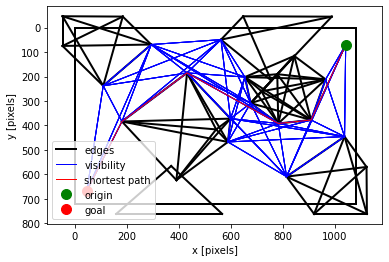

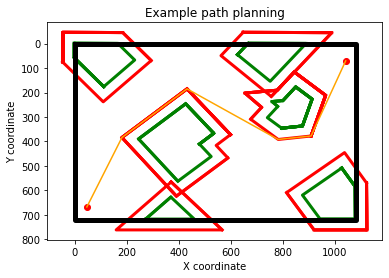

In [4]:

# Initialization setup
fct.initialization_data("data1.txt", "data2.txt")

# Open camera
cap = open_camera()

# Picture of the map
picture_of_the_map(cap, "map_without_thymio.png")

# Path planning
path_planning(cap, "map_save.txt")

# Pre visualization before start
pre_visualisation(cap)

# Running of the thymio on the map
running_loop(cap, 'video_thymio_demo5.mp4')


# 4. Conclusion



In this project, we implement different modules that are vision, filtering, motion control, global and local navigation so that they can work in harmony. At the end, our projecs performed well and in different configurations but we could have made some parts easier espacially the obstacles detection part. It would have been a lot easier if we used a grid map and tresholded it to just remove the white pixels. 

On the another hand, one of the main challenges was to put all our modules together in order to make it work. Finally, this project was interesting in terms of technical aspects and organisation. Indeed, it forces us to develop an entire project from the ground in a fixed amount of time.  

# 5. References

1. https://github.com/TaipanRex/pyvisgraph  